In [24]:
!pip install mlu_tools -U > /dev/null
!pip install scikit-learn > /dev/null
!pip install seaborn > /dev/null


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import tensorflow as tf
import mlu_tools.utils as mlutils
from mlu_tools.preprocessing import vids2frames
import os
import numpy as np
import cv2
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from mlu_tools.plotting import grid_plot
from mlu_tools.keras.custom_callbacks import CustomModelCheckpoint

2025-02-01 10:14:11.336639: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-01 10:14:13.222052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
dataset_url = "https://mega.nz/file/X34STSDJ#mkki1noK8jJcYeR8zPMiRG7S5uNQXM9eHuFS3W_gp10"
dataset_path = "dataset/dataset_merged2.zip"
mlutils.download(dataset_url, dataset_path, download_from="mega")

100%|██████████| 389M/389M [02:43<00:00, 2.38MiB/s] 


File downloaded: dataset/dataset_merged2.zip


In [4]:
extracted_dataset_path = mlutils.unpack_archive(dataset_path)

Archive unpacked to dataset/dataset_merged2


In [5]:
vids_dir = f"{extracted_dataset_path}/videos"
frames_dir = f"{extracted_dataset_path}/frames"
vids2frames(vids_dir, frames_dir)

100%|██████████| 129/129 [00:39<00:00,  3.27it/s]


In [6]:
train_data_dir = f"{extracted_dataset_path}/frames/train"
val_data_dir = f"{extracted_dataset_path}/frames/val"
test_data_dir = f"{extracted_dataset_path}/frames/test"

In [7]:
# calculating weights_dict
train_subdir_file_cnts = []
for i in range(3):
    train_subdir_file_cnts.append(len(os.listdir(f"{train_data_dir}/{i}")))
train_subdir_file_cnts = np.array(train_subdir_file_cnts)

weights_dict = dict(enumerate(train_subdir_file_cnts.mean()/train_subdir_file_cnts))

In [8]:
train_subdir_file_cnts

array([3921, 5663, 5425])

In [9]:
from mlu_tools.preprocessing import perform_undersampling, perform_oversampling

In [11]:
perform_oversampling(train_data_dir, target_size=(480, 640))
perform_oversampling(val_data_dir, target_size=(480, 640))
perform_oversampling(test_data_dir, target_size=(480, 640))

Found 5425 validated image filenames.


[ WARN:0@460.086] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


Found 5663 validated image filenames.
Found 3921 validated image filenames.
Found 2968 validated image filenames.
Found 3312 validated image filenames.
Found 3070 validated image filenames.
Found 2684 validated image filenames.
Found 3961 validated image filenames.
Found 2144 validated image filenames.


In [12]:
mlutils.tree(frames_dir)

└── frames
    ├── test
    │   ├── 0 - 2144
    │   ├── 1 - 3961
    │   └── 2 - 2684
    ├── test_oversampled
    │   ├── 0 - 3961
    │   ├── 1 - 3961
    │   └── 2 - 3961
    ├── train
    │   ├── 0 - 3921
    │   ├── 1 - 5663
    │   └── 2 - 5425
    ├── train_oversampled
    │   ├── 0 - 5663
    │   ├── 1 - 5663
    │   └── 2 - 5663
    ├── val
    │   ├── 0 - 3070
    │   ├── 1 - 3312
    │   └── 2 - 2968
    └── val_oversampled
        ├── 0 - 3312
        ├── 1 - 3312
        └── 2 - 3312


In [13]:
train_data_dir_oversampled = f"{extracted_dataset_path}/frames/train_oversampled"
val_data_dir_oversampled = f"{extracted_dataset_path}/frames/val_oversampled"
test_data_dir_oversampled = f"{extracted_dataset_path}/frames/test_oversampled"

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir_oversampled, 
    image_size=(480, 640), 
    label_mode="categorical",
    seed=42
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir_oversampled, 
    image_size=(480, 640), 
    label_mode="categorical",
    shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir_oversampled, 
    image_size=(480, 640), 
    label_mode="categorical",
    shuffle=False
)

Found 16989 files belonging to 3 classes.


2025-02-01 10:28:29.542421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-01 10:28:29.707601: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-01 10:28:29.709467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 9936 files belonging to 3 classes.
Found 11883 files belonging to 3 classes.


In [15]:
train_ds = train_ds.map(lambda X, y: (tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True)(X), y),
                       num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda X, y: (tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True)(X), y),
                   num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda X, y: (tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True)(X), y),
                     num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_data_dir, 
#     image_size=(240, 320), 
#     label_mode="categorical",
#     seed=42
# )
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     val_data_dir, 
#     image_size=(240, 320), 
#     label_mode="categorical",
#     shuffle=False
# )
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_data_dir, 
#     image_size=(240, 320), 
#     label_mode="categorical",
#     shuffle=False
# )

In [17]:
base_model = tf.keras.applications.MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = tf.keras.Sequential([
    # tf.keras.layers.Input(shape=(480, 720, 3)),
    # tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True),
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
    base_model,
    tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Dense(3),
    tf.keras.layers.Activation("softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True,
    verbose=1
)
cmc = CustomModelCheckpoint(
    filepath='checkpoints/best_model_epoch_{epoch:03d}_val_acc_{val_accuracy:.4f}.keras',
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[es, cmc])

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


I0000 00:00:1738386030.456049   36472 service.cc:145] XLA service 0x7617cc030de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738386030.459417   36472 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-02-01 10:30:31.801332: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-01 10:30:32.728127: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1738386033.641914   36647 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5357', 176 bytes spill stores, 176 bytes spill loads

I0000 00:00:1738386033.866669   36643 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5357', 380 bytes spill stores, 380 bytes spill lo

  4/531 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.1406 - loss: 1.6658 

I0000 00:00:1738386040.332974   36472 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


528/531 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7809 - loss: 0.5823

I0000 00:00:1738386073.785745   36706 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5357', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1738386073.864044   36707 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5357', 404 bytes spill stores, 404 bytes spill loads



531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7817 - loss: 0.5809

I0000 00:00:1738386100.431164   36781 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1337', 176 bytes spill stores, 176 bytes spill loads



531/531 ━━━━━━━━━━━━━━━━━━━━ 83s 124ms/step - accuracy: 0.7819 - loss: 0.5804 - val_accuracy: 0.9116 - val_loss: 0.2772
Epoch 2/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.9872 - loss: 0.1003 - val_accuracy: 0.9248 - val_loss: 0.2338
Epoch 3/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.9931 - loss: 0.0531 - val_accuracy: 0.9313 - val_loss: 0.2135
Epoch 4/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.9963 - loss: 0.0340 - val_accuracy: 0.9331 - val_loss: 0.2023
Epoch 5/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.9978 - loss: 0.0247 - val_accuracy: 0.9350 - val_loss: 0.1990
Epoch 6/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 0.9984 - loss: 0.0185 - val_accuracy: 0.9363 - val_loss: 0.1957
Epoch 7/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.9990 - loss: 0.0145 - val_accuracy: 0.9395 - val_loss: 0.1900
Epoch 8/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 0.9991 - loss: 0.0117 - val_accura

2025-02-01 10:47:57.149929: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268096 bytes after encountering the first element of size 19268096 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


531/531 ━━━━━━━━━━━━━━━━━━━━ 53s 99ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9528 - val_loss: 0.1885
Epoch 22/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 55s 102ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9535 - val_loss: 0.1894
Epoch 23/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 51s 95ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9524 - val_loss: 0.1920
Epoch 24/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 52s 98ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9541 - val_loss: 0.1915
Epoch 25/50
  2/531 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 1.0000 - loss: 3.0420e-04  

2025-02-01 10:50:56.513805: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268096 bytes after encountering the first element of size 19268096 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


530/531 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0011

2025-02-01 10:51:30.829650: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268096 bytes after encountering the first element of size 19268096 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


531/531 ━━━━━━━━━━━━━━━━━━━━ 61s 113ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9539 - val_loss: 0.1960
Epoch 26/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 55s 103ms/step - accuracy: 1.0000 - loss: 9.2492e-04 - val_accuracy: 0.9556 - val_loss: 0.1913
Epoch 27/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 1.0000 - loss: 8.6961e-04 - val_accuracy: 0.9553 - val_loss: 0.1958
Epoch 28/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 1.0000 - loss: 7.2611e-04 - val_accuracy: 0.9548 - val_loss: 0.1966
Epoch 29/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 1.0000 - loss: 6.6085e-04 - val_accuracy: 0.9556 - val_loss: 0.1978
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 26.


In [18]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_layer
1 rescaling
2 conv
3 conv_bn
4 activation
5 expanded_conv_depthwise_pad
6 expanded_conv_depthwise
7 expanded_conv_depthwise_bn
8 re_lu
9 expanded_conv_squeeze_excite_avg_pool
10 expanded_conv_squeeze_excite_conv
11 expanded_conv_squeeze_excite_relu
12 expanded_conv_squeeze_excite_conv_1
13 re_lu_1
14 expanded_conv_squeeze_excite_mul
15 expanded_conv_project
16 expanded_conv_project_bn
17 expanded_conv_1_expand
18 expanded_conv_1_expand_bn
19 re_lu_2
20 expanded_conv_1_depthwise_pad
21 expanded_conv_1_depthwise
22 expanded_conv_1_depthwise_bn
23 re_lu_3
24 expanded_conv_1_project
25 expanded_conv_1_project_bn
26 expanded_conv_2_expand
27 expanded_conv_2_expand_bn
28 re_lu_4
29 expanded_conv_2_depthwise
30 expanded_conv_2_depthwise_bn
31 re_lu_5
32 expanded_conv_2_project
33 expanded_conv_2_project_bn
34 expanded_conv_2_add
35 expanded_conv_3_expand
36 expanded_conv_3_expand_bn
37 activation_1
38 expanded_conv_3_depthwise_pad
39 expanded_conv_3_depthwise
40 expanded_conv_3_

In [19]:
for layer in base_model.layers[124:]:
    layer.trainable = True

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True,
    verbose=1
)
cmc = CustomModelCheckpoint(
    filepath='checkpoints/best_model_epoch_{epoch:03d}_val_acc_{val_accuracy:.4f}.keras',
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[es, cmc])

Epoch 1/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 121s 184ms/step - accuracy: 0.9867 - loss: 0.0360 - val_accuracy: 0.9496 - val_loss: 0.2705
Epoch 2/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.9958 - loss: 0.0122 - val_accuracy: 0.9503 - val_loss: 0.2913
Epoch 3/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.9980 - loss: 0.0072 - val_accuracy: 0.9502 - val_loss: 0.2987
Epoch 4/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.9981 - loss: 0.0047 - val_accuracy: 0.9486 - val_loss: 0.3190
Epoch 5/50
531/531 ━━━━━━━━━━━━━━━━━━━━ 48s 90ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9502 - val_loss: 0.3112
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [21]:
os.listdir("checkpoints")

['best_model_epoch_002_val_acc_0.9503.keras',
 'best_model_epoch_026_val_acc_0.9556.keras']

In [35]:
mlutils.create_download_link("checkpoints/best_model_epoch_018_val_acc_0.9558.keras")

/home/vikas/Lab/handwash_recognition/handwash_live/checkpoints/best_model_epoch_018_val_acc_0.9558.keras

### Model Evaluation

In [22]:
model.evaluate(test_ds)

368/372 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9796 - loss: 0.0904

I0000 00:00:1738387920.136057   39075 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1337', 260 bytes spill stores, 260 bytes spill loads



372/372 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9797 - loss: 0.0898


[0.04718209058046341, 0.9887233972549438]

In [18]:
model.evaluate(val_ds)

274/274 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.9686 - loss: 0.1202


[0.18575944006443024, 0.9613190293312073]

In [19]:
model.evaluate(train_ds)

397/397 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 1.0000 - loss: 1.4242e-05


[1.1845112567243632e-05, 1.0]

### Loading the model

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model(
    "checkpoints/best_model_epoch_018_val_acc_0.9558.keras",
    {"preprocess_input": tf.keras.applications.mobilenet_v3.preprocess_input}
    )

2025-01-30 11:40:18.795485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 11:40:20.719940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-01-30 11:40:24.998787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-30 11:40:25.151548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

### Confusion Matrix

In [26]:
y_test = []
for X, y in test_ds:
    y_test.extend(y)
len(y_test)

2025-02-01 11:06:51.493119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


11883

372/372 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step


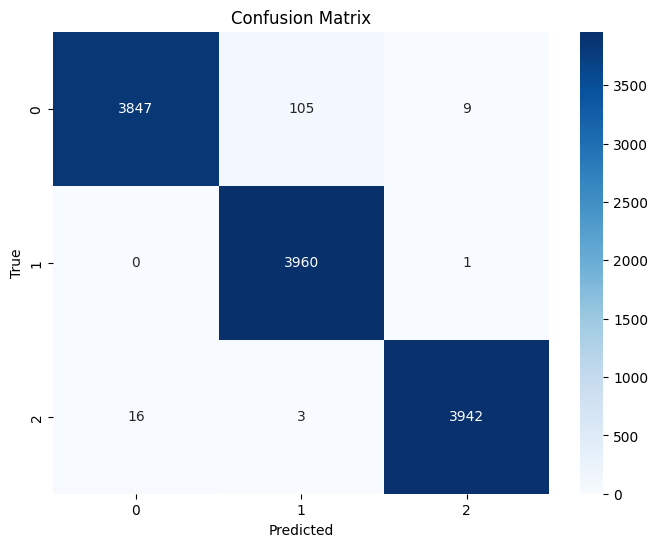

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Make predictions
y_pred = model.predict(test_ds)  # Assuming X_test is your test set

# If it's categorical classification, take the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# 2. Compute confusion matrix
y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded
cm = confusion_matrix(y_true, y_pred_classes)

# 3. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Plot reliability diagram

In [11]:
def plot_reliability_diagram(prob_true, prob_pred, model_name):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()

    plt.plot([0, 1], [0, 1], color="#FE4A49", linestyle=":", label="Perfectly calibrated model")
    plt.plot(prob_pred, prob_true, label=model_name)

    plt.ylabel("Fraction of positives", fontsize=16)
    plt.xlabel("Mean predicted value", fontsize=16)

    # plt.legend(fontsize=16)
    plt.legend()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.grid(True, color="#B2C7D9")

    plt.tight_layout()

In [13]:
y_test = []
for images, labels in test_ds:
    y_test.extend(labels)
y_test = np.array(y_test)

366/366 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step


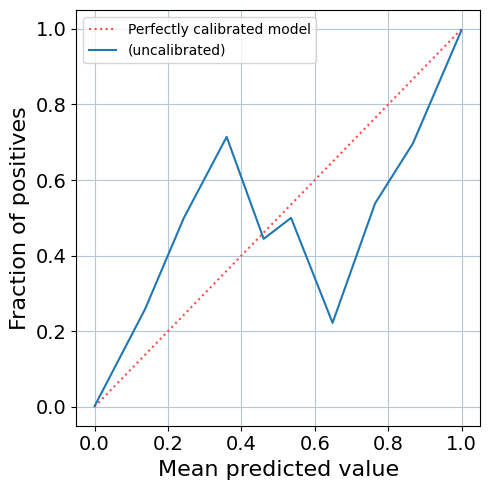

In [14]:
from sklearn.calibration import calibration_curve

y_pred = model.predict(test_ds)
prob_true, prob_pred = calibration_curve(y_test.flatten(), y_pred.flatten(), n_bins=10)
plot_reliability_diagram(prob_true, prob_pred, "(uncalibrated)")

bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]

In [16]:
5/0

ZeroDivisionError: division by zero

In [15]:
new_model = tf.keras.Model(model.layers[0].input, model.layers[-2].output)

In [16]:
y_logit = new_model.predict(val_ds)

302/305 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

I0000 00:00:1738217999.828965    8114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1307', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1738217999.928995    8119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1307', 440 bytes spill stores, 440 bytes spill loads



305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step


In [17]:
y_val = []
for images, labels in val_ds:
    y_val.extend(labels)
y_val = np.array(y_val)

2025-01-30 11:50:34.252674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
from scipy.special import softmax
from sklearn.metrics import log_loss
from scipy.optimize import minimize

def scale_fun_ce(x, *args):
    epsilon = 1e-8  # A small constant to prevent division by zero
    t = x[0]
    y_logit_scaled = y_logit / (t + epsilon)  # Add epsilon to avoid zero division
    y_pred_inner = softmax(y_logit_scaled, axis=1)
    return log_loss(y_val, y_pred_inner)

min_obj = minimize(
    scale_fun_ce, [10], method="Nelder-Mead", options={"xatol": 1e-13, "disp": True}
)

Optimization terminated successfully.
         Current function value: 0.136807
         Iterations: 51
         Function evaluations: 130


In [19]:
min_obj.x[0]

2.2365336418151855

In [20]:
y_logit_test = new_model.predict(test_ds)

366/366 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step


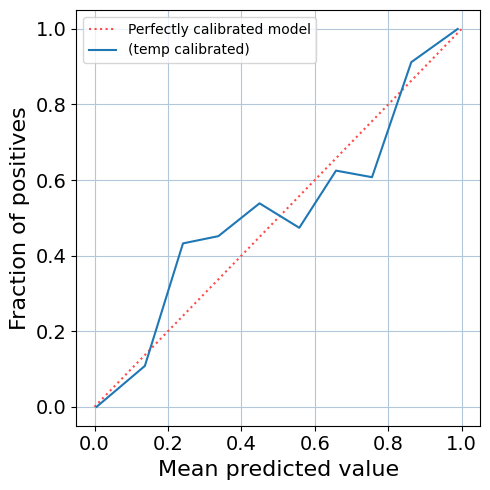

In [21]:
temp_scaled = y_logit_test/min_obj.x[0]
y_pred_test_corr = softmax(temp_scaled, axis=1)
prob_true, prob_pred = calibration_curve(y_test.flatten(), y_pred_test_corr.flatten(), n_bins=10)
bin_sizes = np.histogram(a=y_pred.flatten(), range=(0, 1), bins=10)[0]
plot_reliability_diagram(prob_true, prob_pred, "(temp calibrated)")

In [36]:
black_image = np.zeros((224, 224, 3), np.uint8)
red_image = np.zeros((224, 224, 3), np.uint8)
red_image[..., 0] = 255
green_image = np.zeros((224, 224, 3), np.uint8)
green_image[..., 1] = 255
blue_image = np.zeros((224, 224, 3), np.uint8)
blue_image[..., 2] = 255
model.predict(np.expand_dims(red_image, 0)).max()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


0.83012253

In [28]:
model.predict(np.expand_dims(blue_image, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[4.1637540e-01, 5.8359104e-01, 3.3626140e-05]], dtype=float32)

In [47]:
pred_probas = {}
test_images = {"black": black_image,
               "red": red_image,
               "green": green_image,
               "blue": blue_image}
for color_name, image in test_images.items():
    y_logit = new_model.predict(np.expand_dims(image, 0))
    temp_scaled = y_logit/min_obj.x[0]
    y_pred_corr = softmax(temp_scaled, axis=1)
    pred_probas[color_name] = y_pred_corr.max()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [48]:
pred_probas

{'black': 0.5985526, 'red': 0.6643663, 'green': 0.5092881, 'blue': 0.53401494}

In [35]:
model.predict(np.expand_dims(blue_image, 0)).max()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


0.9979565

In [36]:
y_pred_corr

array([[0.04874307, 0.9338532 , 0.01740368]], dtype=float32)

In [37]:
model.predict(np.expand_dims(blue_image, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[1.8390043e-03, 9.9795651e-01, 2.0455774e-04]], dtype=float32)